In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os,sys
from PIL import Image

%load_ext autoreload
%autoreload 2

# Loading the dataset

In [19]:
import helper

In [20]:
# Loaded a set of images
root_dir = "Datasets/training/"

n = 100

imgs = []
gt_imgs = []

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
print("Loading " + str(n) + " images")
imgs = [helper.load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [helper.load_image(gt_dir + files[i]) for i in range(n)]

Loading 100 images
Loading 100 images


## Feture processing 

In [21]:
import albumentations as albu

In [22]:
def aug_with_crop(image_size = 256, crop_prob = 1):
    return albu.Compose([
        albu.RandomCrop(width = image_size, height = image_size, p=crop_prob),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.25),
        albu.IAAEmboss(p=0.25),
        albu.Blur(p=0.01, blur_limit = 3),
        #albu.OneOf([
            #albu.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            #albu.GridDistortion(p=0.5),
            #albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)      
        #], p=0.8)
    ], p = 1)

In [23]:
def augment_dataset(imgs, gt_imgs):
    for i in range(100):
        augmented = aug_with_crop(image_size = 400)(image=imgs[i], mask=gt_imgs[i])
        imgs.append(augmented['image'])
        gt_imgs.append(augmented['mask'])

In [24]:
augment_dataset(imgs, gt_imgs)
augment_dataset(imgs, gt_imgs)

In [25]:
len(imgs)

300

In [26]:
idx = 290

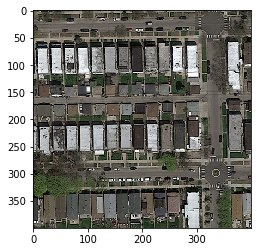

In [27]:
plt.imshow(imgs[idx])

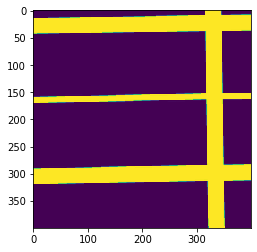

In [28]:
plt.imshow(gt_imgs[idx])

In [29]:
len(imgs)

300

In [30]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

n = 300

img_patches = [helper.img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [helper.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# CNN

In [31]:
from tensorflow.keras import datasets, layers, models

## Layers

In [36]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 3)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6402      
Total params: 99,650
Trainable params: 99,650
Non-trainable params: 0
__________________________________________________

## Training

In [38]:
from tensorflow.keras.utils import to_categorical

In [39]:
y = helper.patches_labelization(gt_patches)
y = to_categorical(y)

model.compile(loss = 'categorical_crossentropy',  optimizer = 'adam', metrics = ['accuracy'])
h = model.fit(img_patches, y, batch_size = 32, epochs = 4, validation_split = 0.2)

Train on 150000 samples, validate on 37500 samples
Epoch 1/4
150000/150000 [==============================] - 104s 690us/sample - loss: 0.5360 - accuracy: 0.7236 - val_loss: 0.5247 - val_accuracy: 0.7353
Epoch 2/4
150000/150000 [==============================] - 107s 716us/sample - loss: 0.4943 - accuracy: 0.7543 - val_loss: 0.5427 - val_accuracy: 0.7145
Epoch 3/4
150000/150000 [==============================] - 101s 672us/sample - loss: 0.4748 - accuracy: 0.7682 - val_loss: 0.5048 - val_accuracy: 0.7491
Epoch 4/4
150000/150000 [==============================] - 103s 689us/sample - loss: 0.4612 - accuracy: 0.7764 - val_loss: 0.5194 - val_accuracy: 0.7413


## Predictions

In [40]:
predictions = model.predict(img_patches)

In [41]:
predictions = np.squeeze(helper.binarize_predictions(predictions))

In [42]:
predictions = predictions[:,1]

In [43]:
predictions

array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)

### Displaying predictions

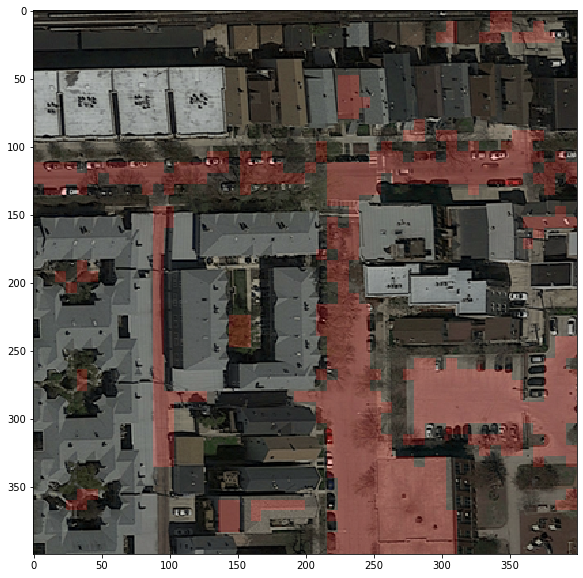

In [290]:
# Display prediction as an image
img_idx = 49
img_indexed = imgs[img_idx]
img_pat = helper.img_crop(img_indexed, patch_size, patch_size)
img_pat = np.asarray(img_pat)
prediction = model.predict(img_pat)

prediction = prediction[:,1]

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]

prediction = helper.binarize_predictions(prediction)
prediction = single_patch_cleaner(prediction.reshape((w//patch_size, h//patch_size))).flatten()

predicted_im = helper.label_to_img(w, h, patch_size, patch_size, prediction)

cimg = helper.concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = helper.make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

# Create Submission

In [291]:
import submission as sub

In [292]:
n = 50
patch_size = 16

img_test = []

for i in range(1, 51):
    image_filename = 'Datasets/test_set_images/test_' + str(i) + '/test_' + str(i) + '.png' 
    img_test.append(helper.load_image(image_filename))

img_patches_test = [helper.img_crop(img_test[i], patch_size, patch_size) for i in range(n)]
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

In [248]:
predictions = model.predict(img_patches_test)
predictions = np.squeeze(helper.binarize_predictions(predictions))

In [249]:
predictions = predictions[:,1]

In [251]:
sub.create_pred_images(predictions, patch_size)

In [170]:
submission_filename = 'submission.csv'
   
sub.create_submission(submission_filename)

File 'submission.csv' created


### Displaying predictions

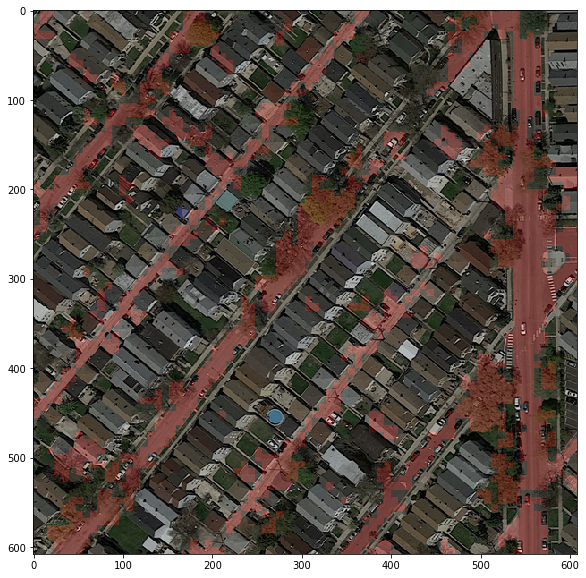

In [296]:
# Display prediction as an image
img_idx = 49
img_indexed = img_test[img_idx]
img_pat = helper.img_crop(img_indexed, patch_size, patch_size)
img_pat = np.asarray(img_pat)
prediction = model.predict(img_pat)

prediction = prediction[:,1]

w = img_test[img_idx].shape[0]
h = img_test[img_idx].shape[1]

prediction = helper.binarize_predictions(prediction)
prediction = single_patch_cleaner(prediction.reshape((w//patch_size, h//patch_size)))

predicted_im = helper.label_to_img(w, h, patch_size, patch_size, prediction.flatten())
cimg = helper.concatenate_images(img_test[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = helper.make_img_overlay(img_test[img_idx], predicted_im)

plt.imshow(new_img)